In [149]:
import Quandl
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import scipy

In [6]:
sys.path.append('/Users/christianjunge/OneDrive/AC297Capstone/AC297_beta/work/Tang')

In [8]:
import stockSelection
import beta_hedging
import get_beta
import get_beta_demo

In [9]:
## This was a random portfolio that Haosu selected

rand_portfolio =['MAR',
 'AYI',
 'SHW',
 'LUX',
 'LFL',
 'CSC',
 'SON',
 'CBS',
 'CNO',
 'DNP',
 'CATY',
 'BRFS',
 'BBT',
 'SINA']

In [12]:
portfolio = stockSelection.getStocks(rand_portfolio)

['MAR', 'AYI', 'SHW', 'LUX', 'LFL', 'CSC', 'SON', 'CBS', 'CNO', 'DNP', 'CATY', 'BRFS', 'BBT', 'SINA']
MAR AYI SHW LUX LFL CSC SON CBS CNO DNP CATY BRFS BBT SINA


In [14]:
port_df = pd.concat(portfolio, axis=1, join='inner')

In [18]:
port_df.columns = [u'AYI', u'BBT', u'BRFS', u'CATY', u'CBS', u'CNO', u'CSC', u'DNP', u'LFL', u'LUX', u'MAR', u'SHW', u'SINA', u'SON']

In [29]:
## Test over just 2014
port_df = port_df[(port_df.index>'2013-12-31') & (port_df.index<'2015-01-01')]

In [33]:
stockUniverse = stockSelection.getStockUniverse()

In [ ]:
## I use this iterative method to make the portfolio instead of getSamplePortfolio because it yields portfolios with 
##    incomplete data, and the inner merge yields just the rows that are all in common.  

trim_start = '2014-01-02'
trim_end='2014-12-31'
market_df = pd.DataFrame()

while(len(market_df.columns)<50):
    potential_stock = stockSelection.getSamplePortfolio(stockUniverse, n=1, sector="Technology");
    potential_stock_df = stockSelection.getStocks(potential_stock, trim_start=trim_start, trim_end=trim_end);
    print
    print 
    print
    try:
        potential_stock_series = potential_stock_df[potential_stock[0]]
        if len(potential_stock_series)==252: 
            market_df[potential_stock[0]] = potential_stock_series['Close']
    except KeyError:
        pass

In [176]:
market_df.columns

Index([u'ASML', u'FDS', u'STX', u'ACIW', u'MIDD', u'FSLR', u'MRVL', u'MLNX',
       u'CA', u'WIT', u'SSNC', u'TSM', u'PNR', u'RHT', u'MANH', u'CSCO',
       u'CLGX', u'ADSK', u'MPWR', u'SYNT', u'IDTI', u'EA', u'IM', u'ELLI',
       u'FCS', u'YY', u'ARRS', u'CSC', u'CTXS', u'STM', u'ADI', u'GOOG',
       u'DCM', u'NUAN', u'YOKU', u'OTEX', u'ANSS', u'GWRE', u'LLTC', u'CVG',
       u'FFIV', u'INTC', u'VRSN', u'MXIM', u'N', u'SAIC', u'YHOO', u'MSI',
       u'NTCT', u'TXN'],
      dtype='object')

In [ ]:
### Now I equalize each asset in the portfolio and market over share price, so that each asset has equal weight

In [57]:
def equalize_by_top_row(df):
    top_row_sum = np.sum(df.iloc[0,:])
    arr_to_return = np.zeros(df.shape)
    for c in range(len(df.columns)):
        for r in range(df.shape[0]):
            arr_to_return[r,c] = df.iloc[r,c]*top_row_sum/df.iloc[0,c]
    return pd.DataFrame(arr_to_return,index=df.index, columns=df.columns)

In [59]:
port_df_eqd = equalize_by_top_row(port_df)

In [60]:
market_df_eqd = equalize_by_top_row(market_df)

In [ ]:
## Now I combine each df into a single column that is the average over all the assets, and correct for starting share
##    price

In [63]:
port_df_series = port_df_eqd.apply(np.mean, axis=1)

In [67]:
port_df_series = port_df_series.apply(lambda x: 100*x/port_df_series.iloc[0])

In [69]:
market_df_series = market_df_eqd.apply(np.mean, axis=1)

In [70]:
market_df_series = market_df_series.apply(lambda x: 100*x/market_df_series.iloc[0])

In [ ]:
## Now I take the daily difference to get daily returns

In [77]:
port_returns = np.diff(port_df_series)

In [76]:
market_returns = np.diff(market_df_series)

In [ ]:
## Now I get daily beta values

In [87]:
alpha, betas = get_beta.get_beta(port_returns, market_returns)

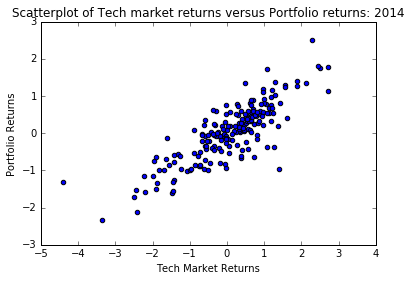

In [142]:
plt.scatter(market_returns[60:], port_returns[60:])
plt.title('Scatterplot of Tech market returns versus Portfolio returns: 2014')
plt.xlabel('Tech Market Returns')
plt.ylabel('Portfolio Returns');

In [140]:
hedged_returns = port_returns[60:] - betas*market_returns[60:]

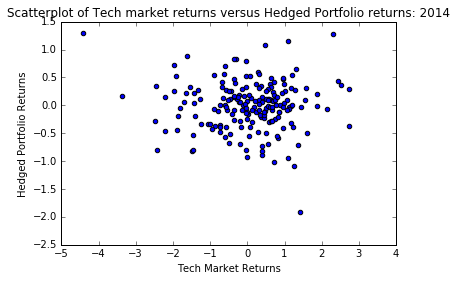

In [143]:
plt.scatter(market_returns[60:], hedged_returns)
plt.title('Scatterplot of Tech market returns versus Hedged Portfolio returns: 2014')
plt.xlabel('Tech Market Returns')
plt.ylabel('Hedged Portfolio Returns');

In [99]:
SP500 = stockSelection.getStocks(['INDEX_GSPC'])['INDEX_GSPC']

['INDEX_GSPC']
INDEX_GSPC


In [102]:
SP500.columns=['SP500']

In [105]:
## Select 2014
SP500=SP500[(SP500.index>='2014-01-01') & (SP500.index<='2014-12-31') ]

In [120]:
## Equalize by first day
SP500 = SP500.apply(lambda x: 100*x/SP500.iloc[0].values)

In [133]:
## Daily returns
SP500_returns = np.diff(SP500.values.flatten())

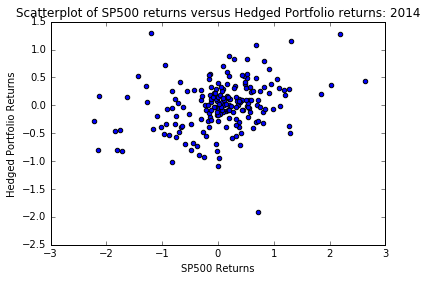

In [145]:
plt.scatter(SP500_returns[60:], hedged_returns)

plt.title('Scatterplot of SP500 returns versus Hedged Portfolio returns: 2014')
plt.xlabel('SP500 Returns')
plt.ylabel('Hedged Portfolio Returns');

In [182]:
## Correlation between hedged portfolio and SP500
scipy.stats.pearsonr(hedged_returns, SP500_returns[60:])

(0.30501401340403927, 1.7835902295161677e-05)

In [183]:
## Correlation between unhedged portfolio and SP500
scipy.stats.pearsonr(port_returns[60:], SP500_returns[60:])

(0.88661645787078147, 3.32553261290513e-65)

In [184]:
## Correlation between unhedged portfolio and Tech Market
scipy.stats.pearsonr(port_returns[60:], market_returns[60:])

(0.82999662331050472, 8.3719756150645876e-50)

In [154]:
## Volatility of Hedged Returns
np.std(hedged_returns)

0.44384266346017071

In [186]:
## Volatility of S&P 500
np.std(SP500_returns[60:])

0.74950518235124752

In [187]:
## Volatility of Tech hedge
np.std(market_returns[60:])

1.0931200765654561

In [155]:
## Volatility of Unhedged Returns
np.std(port_returns[60:])

0.77986902608033448

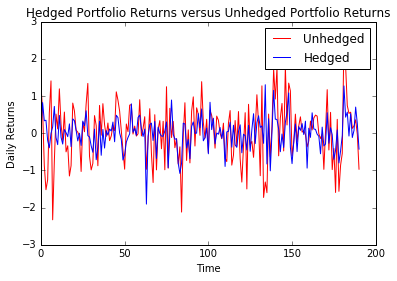

In [190]:
plt.plot(port_returns[60:], label="Unhedged", color='r')
plt.plot(hedged_returns, color='b',label='Hedged')
plt.title("Hedged Portfolio Returns versus Unhedged Portfolio Returns")
plt.xlabel("Time")
plt.ylabel("Daily Returns")
plt.legend();

In [161]:
## Now compare against the same portfolio hedged against the SP500

alpha, betas = get_beta.get_beta(port_returns, SP500_returns)
SP500_hedged_returns = port_returns[60:] - betas*SP500_returns[60:]

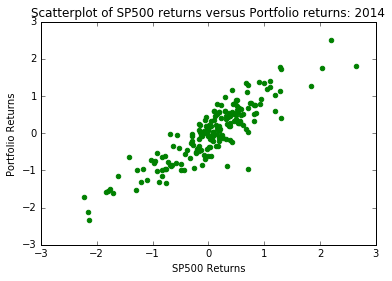

In [178]:
plt.scatter(SP500_returns[60:], port_returns[60:], color='g')
plt.title('Scatterplot of SP500 returns versus Portfolio returns: 2014')
plt.xlabel('SP500 Returns')
plt.ylabel('Portfolio Returns');

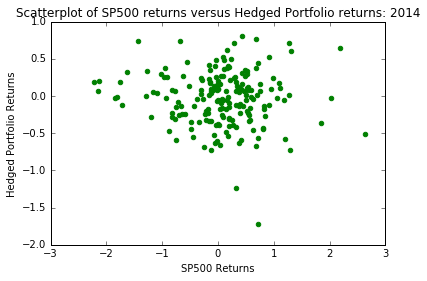

In [179]:
plt.scatter(SP500_returns[60:], SP500_hedged_returns, color='g')
plt.title('Scatterplot of SP500 returns versus Hedged Portfolio returns: 2014')
plt.xlabel('SP500 Returns')
plt.ylabel('Hedged Portfolio Returns');

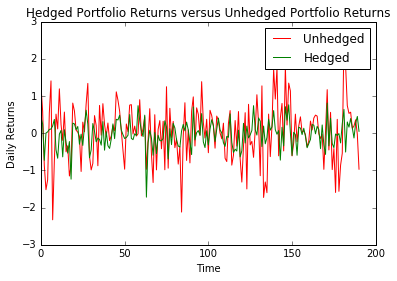

In [189]:
plt.plot(port_returns[60:], label="Unhedged", color='r')
plt.plot(SP500_hedged_returns, color='g',label='Hedged')
plt.title("Hedged Portfolio Returns versus Unhedged Portfolio Returns")
plt.xlabel("Time")
plt.ylabel("Daily Returns")
plt.legend();

In [185]:
## Correlation between SP500 hedged portfolio and SP500
scipy.stats.pearsonr(SP500_hedged_returns, SP500_returns[60:])

(-0.070210948871981205, 0.33446631368148827)

In [171]:
## Correlation between unhedged portfolio and SP500
scipy.stats.pearsonr(port_returns[60:], SP500_returns[60:])[0]

0.88661645787078147

In [175]:
## Volatility of Hedged Returns
np.std(SP500_hedged_returns)

0.36212748811643547

In [173]:
## Volatility of Unhedged Returns
np.std(port_returns[60:])

0.77986902608033448